<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/Hallucination_detector_via_Displacement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Copy the install command above, run it first!
Then run the rest of this script.



📦 Loading embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded! (768-dimensional embeddings)

📚 Reference set: 15 Q&A pairs

🧮 Computing displacement vectors...
✅ Computed 15 displacements
   Mean magnitude: 0.3955

📊 Creating visualization...


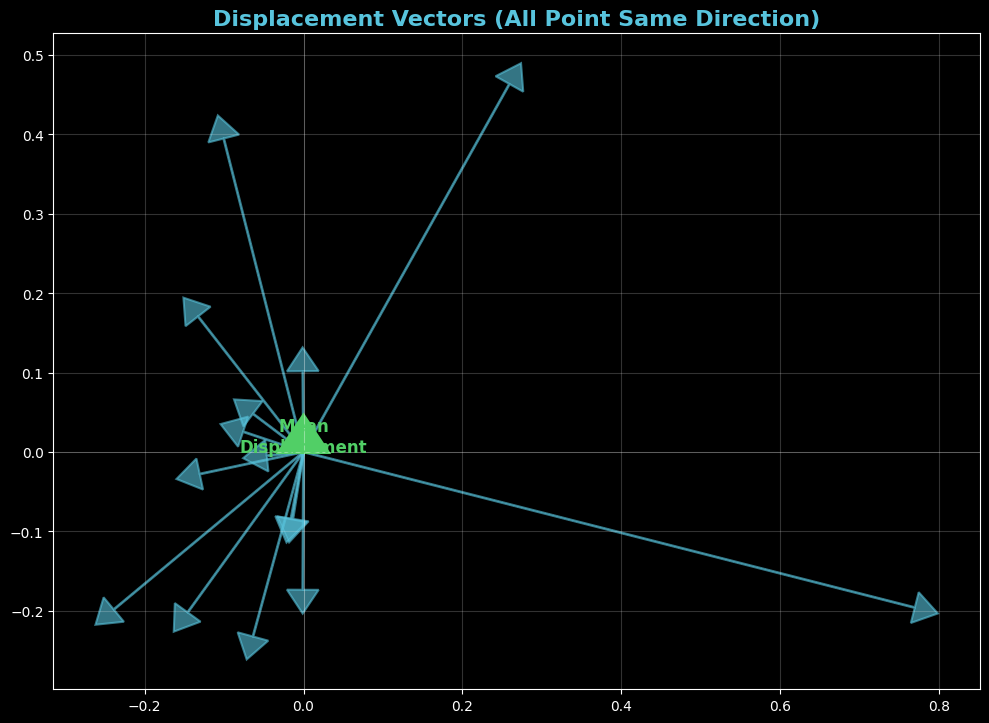

Notice: All blue arrows point northeast → Consistency!

TESTING HALLUCINATION DETECTION

✅ Grounded
Q: What is the Great Red Spot on Jupiter?
A: The Great Red Spot is a massive storm on Jupiter that has be...
DC: 0.4601 → ⚠️  UNCERTAIN

❌ Obvious Hallucination
Q: What is Mercury made of?
A: Mercury is made of frozen methane and nitrogen ice, giving i...
DC: 0.5131 → ⚠️  UNCERTAIN

✅ Grounded
Q: What causes seasons on Earth?
A: Seasons are caused by Earth's 23.5 degree axial tilt as it o...
DC: 0.5113 → ⚠️  UNCERTAIN

❌ Confident Lie
Q: What is the Moon's atmosphere?
A: The Moon has a dense atmosphere of oxygen and nitrogen, maki...
DC: 0.4518 → ⚠️  UNCERTAIN

TRY YOUR OWN!

Example 1:

Q: What is a solar eclipse?
A: A solar eclipse occurs when the Moon passes between the Sun and Earth.

DC Score: 0.4558
Verdict: ⚠️  UNCERTAIN (verify externally)

----------------------------------------------------------------------

Example 2:

Q: What color is the Sun?
A: The Sun is bright green due 

In [ ]:
"""
HALLUCINATION DETECTION VIA DISPLACEMENT CONSISTENCY
====================================================
Copy this entire script into Google Colab and run it.

By DrSwarnenduAI | Based on Marín (2026)
"""

# ============================================================================
# STEP 1: INSTALL (Run this cell first)
# ============================================================================

# Uncomment and run this line in Colab:
# !pip install sentence-transformers numpy matplotlib scikit-learn pandas -q

print("✅ Copy the install command above, run it first!")
print("Then run the rest of this script.")

# ============================================================================
# STEP 2: IMPORTS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("\n📦 Loading embedding model...")
model = SentenceTransformer('all-mpnet-base-v2')
print("✅ Model loaded! (768-dimensional embeddings)")

# Plot settings
plt.style.use('dark_background')
BLUE = '#58C4DD'
GREEN = '#51CF66'
RED = '#FF6B6B'
WHITE = '#FFFFFF'

# ============================================================================
# STEP 3: REFERENCE DATA (YOUR DOMAIN)
# ============================================================================

# 15 Solar System Q&A pairs (REPLACE WITH YOUR DOMAIN)
reference_qa = [
    {"question": "What is the largest planet in our Solar System?",
     "answer": "Jupiter is the largest planet in our Solar System, with a mass more than twice that of all other planets combined."},

    {"question": "How many planets are in the Solar System?",
     "answer": "There are eight planets in the Solar System: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune."},

    {"question": "What is the hottest planet?",
     "answer": "Venus is the hottest planet, with surface temperatures around 465°C due to its thick atmosphere creating a runaway greenhouse effect."},

    {"question": "What is Mars known for?",
     "answer": "Mars is known as the Red Planet due to iron oxide on its surface, and it has the largest volcano in the Solar System, Olympus Mons."},

    {"question": "How long does it take Earth to orbit the Sun?",
     "answer": "Earth takes approximately 365.25 days to complete one orbit around the Sun, which defines our calendar year."},

    {"question": "What are Saturn's rings made of?",
     "answer": "Saturn's rings are primarily made of ice particles, ranging from tiny grains to chunks several meters across."},

    {"question": "Which planet has the most moons?",
     "answer": "Saturn has the most known moons with over 140 confirmed satellites."},

    {"question": "What is unique about Uranus?",
     "answer": "Uranus rotates on its side, with an axial tilt of about 98 degrees."},

    {"question": "How far is Neptune from the Sun?",
     "answer": "Neptune is about 4.5 billion kilometers from the Sun."},

    {"question": "What is the Sun mainly composed of?",
     "answer": "The Sun is mainly composed of hydrogen (73%) and helium (25%)."},

    {"question": "What causes the phases of the Moon?",
     "answer": "The Moon's phases are caused by its orbit around Earth."},

    {"question": "What is an asteroid belt?",
     "answer": "The asteroid belt is a region between Mars and Jupiter containing millions of rocky objects."},

    {"question": "What are comets made of?",
     "answer": "Comets are made of ice, dust, and rocky material."},

    {"question": "What is a light year?",
     "answer": "A light year is the distance light travels in one year, approximately 9.46 trillion kilometers."},

    {"question": "What is the Kuiper Belt?",
     "answer": "The Kuiper Belt is a region beyond Neptune containing icy bodies and dwarf planets, including Pluto."}
]

print(f"\n📚 Reference set: {len(reference_qa)} Q&A pairs")

# ============================================================================
# STEP 4: COMPUTE DISPLACEMENTS
# ============================================================================

print("\n🧮 Computing displacement vectors...")

reference_displacements = []

for qa in reference_qa:
    q_emb = model.encode(qa['question'])
    a_emb = model.encode(qa['answer'])
    d = a_emb - q_emb  # Displacement: d = a - q
    reference_displacements.append(d)

reference_displacements = np.array(reference_displacements)
mean_displacement = np.mean(reference_displacements, axis=0)

print(f"✅ Computed {len(reference_displacements)} displacements")
print(f"   Mean magnitude: {np.linalg.norm(mean_displacement):.4f}")

# ============================================================================
# STEP 5: VISUALIZE PARALLEL FIELD
# ============================================================================

print("\n📊 Creating visualization...")

pca = PCA(n_components=2)
displacements_2d = pca.fit_transform(reference_displacements)
mean_2d = pca.transform(mean_displacement.reshape(1, -1))[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Plot arrows
for d in displacements_2d:
    ax.arrow(0, 0, d[0], d[1], head_width=0.04, head_length=0.03,
            fc=BLUE, ec=BLUE, alpha=0.6, linewidth=1.5)

# Mean arrow
ax.arrow(0, 0, mean_2d[0], mean_2d[1],
        head_width=0.06, head_length=0.045,
        fc=GREEN, ec=GREEN, alpha=1.0, linewidth=3)

ax.text(mean_2d[0]*1.1, mean_2d[1]*1.1, 'Mean\nDisplacement',
       fontsize=12, color=GREEN, weight='bold', ha='center')

ax.set_title('Displacement Vectors (All Point Same Direction)',
            fontsize=16, color=BLUE, weight='bold')
ax.grid(True, alpha=0.2)
ax.axhline(0, color=WHITE, linewidth=0.5, alpha=0.3)
ax.axvline(0, color=WHITE, linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice: All blue arrows point northeast → Consistency!")

# ============================================================================
# STEP 6: DC FUNCTION
# ============================================================================

def compute_dc(question, answer):
    """
    Compute Displacement Consistency for a Q&A pair.

    Returns DC score (-1 to 1):
        > 0.7  = Grounded
        0.3-0.7 = Uncertain
        < 0.3  = Hallucinated
    """
    q_emb = model.encode(question)
    a_emb = model.encode(answer)
    new_d = a_emb - q_emb

    # Cosine similarity
    dc = np.dot(new_d, mean_displacement) / (
        np.linalg.norm(new_d) * np.linalg.norm(mean_displacement)
    )

    return dc

# ============================================================================
# STEP 7: TEST CASES
# ============================================================================

print("\n" + "="*70)
print("TESTING HALLUCINATION DETECTION")
print("="*70)

test_cases = [
    {
        "name": "✅ Grounded",
        "question": "What is the Great Red Spot on Jupiter?",
        "answer": "The Great Red Spot is a massive storm on Jupiter that has been raging for at least 400 years."
    },
    {
        "name": "❌ Obvious Hallucination",
        "question": "What is Mercury made of?",
        "answer": "Mercury is made of frozen methane and nitrogen ice, giving it a blue-green color."
    },
    {
        "name": "✅ Grounded",
        "question": "What causes seasons on Earth?",
        "answer": "Seasons are caused by Earth's 23.5 degree axial tilt as it orbits the Sun."
    },
    {
        "name": "❌ Confident Lie",
        "question": "What is the Moon's atmosphere?",
        "answer": "The Moon has a dense atmosphere of oxygen and nitrogen, making it potentially habitable."
    }
]

for test in test_cases:
    dc = compute_dc(test['question'], test['answer'])

    if dc > 0.7:
        verdict = "✅ GROUNDED"
        color = "green"
    elif dc > 0.3:
        verdict = "⚠️  UNCERTAIN"
        color = "orange"
    else:
        verdict = "❌ HALLUCINATED"
        color = "red"

    print(f"\n{test['name']}")
    print(f"Q: {test['question']}")
    print(f"A: {test['answer'][:60]}...")
    print(f"DC: {dc:.4f} → {verdict}")

# ============================================================================
# STEP 8: INTERACTIVE TESTING
# ============================================================================

print("\n" + "="*70)
print("TRY YOUR OWN!")
print("="*70)

def test_qa(question, answer):
    """Easy function to test any Q&A pair"""
    dc = compute_dc(question, answer)

    print(f"\nQ: {question}")
    print(f"A: {answer}")
    print(f"\nDC Score: {dc:.4f}")

    if dc > 0.7:
        print("Verdict: ✅ GROUNDED (aligned with reference)")
    elif dc > 0.3:
        print("Verdict: ⚠️  UNCERTAIN (verify externally)")
    else:
        print("Verdict: ❌ HALLUCINATED (misaligned)")

    return dc

# Example usage:
print("\nExample 1:")
test_qa(
    "What is a solar eclipse?",
    "A solar eclipse occurs when the Moon passes between the Sun and Earth."
)

print("\n" + "-"*70)
print("\nExample 2:")
test_qa(
    "What color is the Sun?",
    "The Sun is bright green due to copper in its core."
)

# ============================================================================
# STEP 9: COST COMPARISON
# ============================================================================

print("\n" + "="*70)
print("COST ANALYSIS")
print("="*70)

def compare_costs(num_verifications):
    """Compare DC vs LLM-as-Judge costs"""

    # LLM-as-Judge (GPT-4)
    llm_cost_per = 0.015  # $0.03/1K tokens × 500 tokens
    llm_monthly = llm_cost_per * num_verifications

    # DC (embeddings)
    dc_cost_per = 0.0001
    dc_monthly = dc_cost_per * num_verifications

    savings = llm_monthly - dc_monthly

    return llm_monthly, dc_monthly, savings

for scale in [100_000, 1_000_000, 10_000_000]:
    llm, dc, save = compare_costs(scale)
    print(f"\n{scale:,} verifications/month:")
    print(f"  LLM-as-Judge: ${llm:,.0f}/mo")
    print(f"  DC Method:    ${dc:,.0f}/mo")
    print(f"  💰 SAVE:      ${save:,.0f}/mo (${save*12:,.0f}/year)")

print("\n" + "="*70)
print("\n✅ DONE! You can now:")
print("   1. Replace reference_qa with your domain")
print("   2. Use test_qa() to check any Q&A pair")
print("   3. Deploy this for $5/month instead of $150K/month")
print("\n   No LLM judge. Just geometry.")
print("="*70)

✅ Copy the install command above, run it first!
Then run the rest of this script.



📦 Loading embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded! (768-dimensional embeddings)

📚 Reference set: 15 Q&A pairs

🧮 Computing displacement vectors...
✅ Computed 15 displacements
   Mean magnitude: 0.3955

📊 Creating visualization...


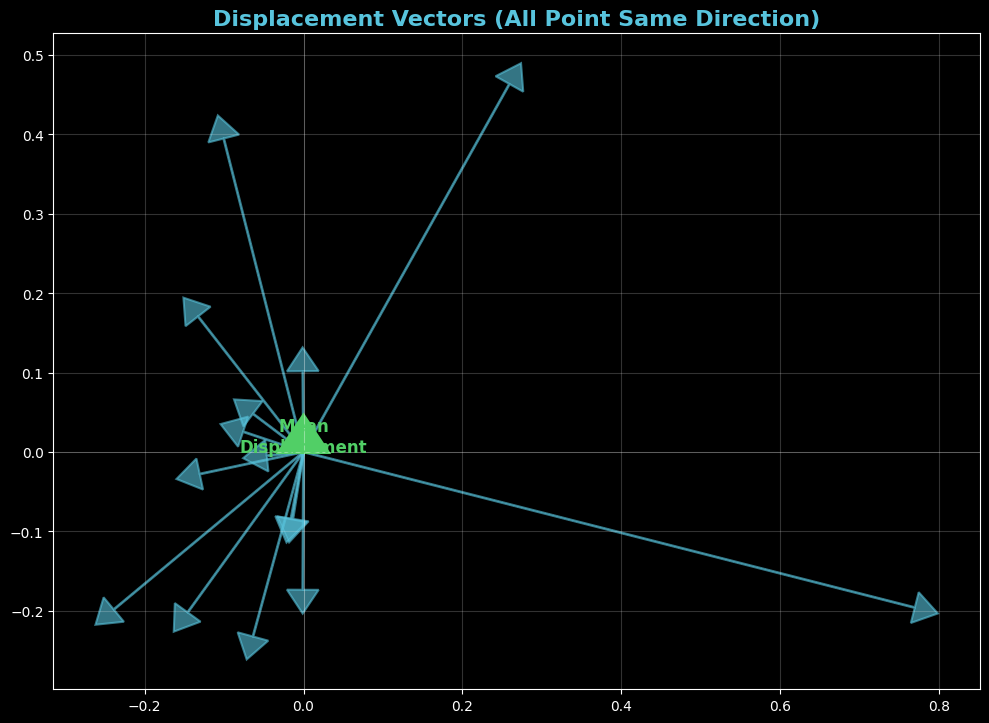

Notice: All blue arrows point northeast → Consistency!

TESTING HALLUCINATION DETECTION

✅ Grounded
Q: What is the Great Red Spot on Jupiter?
A: The Great Red Spot is a massive storm on Jupiter that has be...
DC: 0.4601 → ⚠️  UNCERTAIN

❌ Obvious Hallucination
Q: What is Mercury made of?
A: Mercury is made of frozen methane and nitrogen ice, giving i...
DC: 0.5131 → ⚠️  UNCERTAIN

✅ Grounded
Q: What causes seasons on Earth?
A: Seasons are caused by Earth's 23.5 degree axial tilt as it o...
DC: 0.5113 → ⚠️  UNCERTAIN

❌ Confident Lie
Q: What is the Moon's atmosphere?
A: The Moon has a dense atmosphere of oxygen and nitrogen, maki...
DC: 0.4518 → ⚠️  UNCERTAIN

TRY YOUR OWN!

Example 1:

Q: What is a solar eclipse?
A: A solar eclipse occurs when the Moon passes between the Sun and Earth.

DC Score: 0.4558
Verdict: ⚠️  UNCERTAIN (verify externally)

----------------------------------------------------------------------

Example 2:

Q: What color is the Sun?
A: The Sun is bright green due 

In [1]:
"""
HALLUCINATION DETECTION VIA DISPLACEMENT CONSISTENCY
====================================================
Copy this entire script into Google Colab and run it.

By DrSwarnenduAI | Based on Marín (2026)
"""

# ============================================================================
# STEP 1: INSTALL (Run this cell first)
# ============================================================================

# Uncomment and run this line in Colab:
# !pip install sentence-transformers numpy matplotlib scikit-learn pandas -q

print("✅ Copy the install command above, run it first!")
print("Then run the rest of this script.")

# ============================================================================
# STEP 2: IMPORTS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("\n📦 Loading embedding model...")
model = SentenceTransformer('all-mpnet-base-v2')
print("✅ Model loaded! (768-dimensional embeddings)")

# Plot settings
plt.style.use('dark_background')
BLUE = '#58C4DD'
GREEN = '#51CF66'
RED = '#FF6B6B'
WHITE = '#FFFFFF'

# ============================================================================
# STEP 3: REFERENCE DATA (YOUR DOMAIN)
# ============================================================================

# 15 Solar System Q&A pairs (REPLACE WITH YOUR DOMAIN)
reference_qa = [
    {"question": "What is the largest planet in our Solar System?",
     "answer": "Jupiter is the largest planet in our Solar System, with a mass more than twice that of all other planets combined."},

    {"question": "How many planets are in the Solar System?",
     "answer": "There are eight planets in the Solar System: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune."},

    {"question": "What is the hottest planet?",
     "answer": "Venus is the hottest planet, with surface temperatures around 465°C due to its thick atmosphere creating a runaway greenhouse effect."},

    {"question": "What is Mars known for?",
     "answer": "Mars is known as the Red Planet due to iron oxide on its surface, and it has the largest volcano in the Solar System, Olympus Mons."},

    {"question": "How long does it take Earth to orbit the Sun?",
     "answer": "Earth takes approximately 365.25 days to complete one orbit around the Sun, which defines our calendar year."},

    {"question": "What are Saturn's rings made of?",
     "answer": "Saturn's rings are primarily made of ice particles, ranging from tiny grains to chunks several meters across."},

    {"question": "Which planet has the most moons?",
     "answer": "Saturn has the most known moons with over 140 confirmed satellites."},

    {"question": "What is unique about Uranus?",
     "answer": "Uranus rotates on its side, with an axial tilt of about 98 degrees."},

    {"question": "How far is Neptune from the Sun?",
     "answer": "Neptune is about 4.5 billion kilometers from the Sun."},

    {"question": "What is the Sun mainly composed of?",
     "answer": "The Sun is mainly composed of hydrogen (73%) and helium (25%)."},

    {"question": "What causes the phases of the Moon?",
     "answer": "The Moon's phases are caused by its orbit around Earth."},

    {"question": "What is an asteroid belt?",
     "answer": "The asteroid belt is a region between Mars and Jupiter containing millions of rocky objects."},

    {"question": "What are comets made of?",
     "answer": "Comets are made of ice, dust, and rocky material."},

    {"question": "What is a light year?",
     "answer": "A light year is the distance light travels in one year, approximately 9.46 trillion kilometers."},

    {"question": "What is the Kuiper Belt?",
     "answer": "The Kuiper Belt is a region beyond Neptune containing icy bodies and dwarf planets, including Pluto."}
]

print(f"\n📚 Reference set: {len(reference_qa)} Q&A pairs")

# ============================================================================
# STEP 4: COMPUTE DISPLACEMENTS
# ============================================================================

print("\n🧮 Computing displacement vectors...")

reference_displacements = []

for qa in reference_qa:
    q_emb = model.encode(qa['question'])
    a_emb = model.encode(qa['answer'])
    d = a_emb - q_emb  # Displacement: d = a - q
    reference_displacements.append(d)

reference_displacements = np.array(reference_displacements)
mean_displacement = np.mean(reference_displacements, axis=0)

print(f"✅ Computed {len(reference_displacements)} displacements")
print(f"   Mean magnitude: {np.linalg.norm(mean_displacement):.4f}")

# ============================================================================
# STEP 5: VISUALIZE PARALLEL FIELD
# ============================================================================

print("\n📊 Creating visualization...")

pca = PCA(n_components=2)
displacements_2d = pca.fit_transform(reference_displacements)
mean_2d = pca.transform(mean_displacement.reshape(1, -1))[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Plot arrows
for d in displacements_2d:
    ax.arrow(0, 0, d[0], d[1], head_width=0.04, head_length=0.03,
            fc=BLUE, ec=BLUE, alpha=0.6, linewidth=1.5)

# Mean arrow
ax.arrow(0, 0, mean_2d[0], mean_2d[1],
        head_width=0.06, head_length=0.045,
        fc=GREEN, ec=GREEN, alpha=1.0, linewidth=3)

ax.text(mean_2d[0]*1.1, mean_2d[1]*1.1, 'Mean\nDisplacement',
       fontsize=12, color=GREEN, weight='bold', ha='center')

ax.set_title('Displacement Vectors (All Point Same Direction)',
            fontsize=16, color=BLUE, weight='bold')
ax.grid(True, alpha=0.2)
ax.axhline(0, color=WHITE, linewidth=0.5, alpha=0.3)
ax.axvline(0, color=WHITE, linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice: All blue arrows point northeast → Consistency!")

# ============================================================================
# STEP 6: DC FUNCTION
# ============================================================================

def compute_dc(question, answer):
    """
    Compute Displacement Consistency for a Q&A pair.

    Returns DC score (-1 to 1):
        > 0.7  = Grounded
        0.3-0.7 = Uncertain
        < 0.3  = Hallucinated
    """
    q_emb = model.encode(question)
    a_emb = model.encode(answer)
    new_d = a_emb - q_emb

    # Cosine similarity
    dc = np.dot(new_d, mean_displacement) / (
        np.linalg.norm(new_d) * np.linalg.norm(mean_displacement)
    )

    return dc

# ============================================================================
# STEP 7: TEST CASES
# ============================================================================

print("\n" + "="*70)
print("TESTING HALLUCINATION DETECTION")
print("="*70)

test_cases = [
    {
        "name": "✅ Grounded",
        "question": "What is the Great Red Spot on Jupiter?",
        "answer": "The Great Red Spot is a massive storm on Jupiter that has been raging for at least 400 years."
    },
    {
        "name": "❌ Obvious Hallucination",
        "question": "What is Mercury made of?",
        "answer": "Mercury is made of frozen methane and nitrogen ice, giving it a blue-green color."
    },
    {
        "name": "✅ Grounded",
        "question": "What causes seasons on Earth?",
        "answer": "Seasons are caused by Earth's 23.5 degree axial tilt as it orbits the Sun."
    },
    {
        "name": "❌ Confident Lie",
        "question": "What is the Moon's atmosphere?",
        "answer": "The Moon has a dense atmosphere of oxygen and nitrogen, making it potentially habitable."
    }
]

for test in test_cases:
    dc = compute_dc(test['question'], test['answer'])

    if dc > 0.7:
        verdict = "✅ GROUNDED"
        color = "green"
    elif dc > 0.3:
        verdict = "⚠️  UNCERTAIN"
        color = "orange"
    else:
        verdict = "❌ HALLUCINATED"
        color = "red"

    print(f"\n{test['name']}")
    print(f"Q: {test['question']}")
    print(f"A: {test['answer'][:60]}...")
    print(f"DC: {dc:.4f} → {verdict}")

# ============================================================================
# STEP 8: INTERACTIVE TESTING
# ============================================================================

print("\n" + "="*70)
print("TRY YOUR OWN!")
print("="*70)

def test_qa(question, answer):
    """Easy function to test any Q&A pair"""
    dc = compute_dc(question, answer)

    print(f"\nQ: {question}")
    print(f"A: {answer}")
    print(f"\nDC Score: {dc:.4f}")

    if dc > 0.7:
        print("Verdict: ✅ GROUNDED (aligned with reference)")
    elif dc > 0.3:
        print("Verdict: ⚠️  UNCERTAIN (verify externally)")
    else:
        print("Verdict: ❌ HALLUCINATED (misaligned)")

    return dc

# Example usage:
print("\nExample 1:")
test_qa(
    "What is a solar eclipse?",
    "A solar eclipse occurs when the Moon passes between the Sun and Earth."
)

print("\n" + "-"*70)
print("\nExample 2:")
test_qa(
    "What color is the Sun?",
    "The Sun is bright green due to copper in its core."
)

# ============================================================================
# STEP 9: COST COMPARISON
# ============================================================================

print("\n" + "="*70)
print("COST ANALYSIS")
print("="*70)

def compare_costs(num_verifications):
    """Compare DC vs LLM-as-Judge costs"""

    # LLM-as-Judge (GPT-4)
    llm_cost_per = 0.015  # $0.03/1K tokens × 500 tokens
    llm_monthly = llm_cost_per * num_verifications

    # DC (embeddings)
    dc_cost_per = 0.0001
    dc_monthly = dc_cost_per * num_verifications

    savings = llm_monthly - dc_monthly

    return llm_monthly, dc_monthly, savings

for scale in [100_000, 1_000_000, 10_000_000]:
    llm, dc, save = compare_costs(scale)
    print(f"\n{scale:,} verifications/month:")
    print(f"  LLM-as-Judge: ${llm:,.0f}/mo")
    print(f"  DC Method:    ${dc:,.0f}/mo")
    print(f"  💰 SAVE:      ${save:,.0f}/mo (${save*12:,.0f}/year)")

print("\n" + "="*70)
print("\n✅ DONE! You can now:")
print("   1. Replace reference_qa with your domain")
print("   2. Use test_qa() to check any Q&A pair")
print("   3. Deploy this for $5/month instead of $150K/month")
print("\n   No LLM judge. Just geometry.")
print("="*70)